In [38]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the datasets
metadata_df = pd.read_csv('/Users/harithaanand/Downloads/DATA RA/data/SPGC-metadata-2018-07-18.csv')
kld_scores_df = pd.read_csv('/Users/harithaanand/Downloads/DATA RA/data/KLDscores.csv')
extra_controls_df = pd.read_csv('/Users/harithaanand/Downloads/DATA RA/data/extra_controls.csv')

# Display the first few rows of each dataset to understand their structure
metadata_df_head = metadata_df.head()
kld_scores_df_head = kld_scores_df.head()
extra_controls_df_head = extra_controls_df.head()
metadata_df_head,
kld_scores_df_head,
extra_controls_df_head


,id,subj2_war,subj2_adventure,subj2_comedy,subj2_biography,subj2_romance,subj2_drama,subj2_fantasy,subj2_family,subj2_sciencefiction,...,subj2_horror,subj2_mystery,subj2_crime,subj2_history,subj2_periodicals,subj2_others,speed,sentiment_avg,sentiment_vol,wordcount
0,PG10002,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.224141,0.08737,0.002701,50831.0
1,PG10005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.221966,0.13182,0.003394,70142.0
2,PG10006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.388199,0.18372,0.001003,13193.0
3,PG10007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.301656,0.15722,0.002895,27980.0
4,PG10008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.204838,0.10778,0.003655,65421.0


### Build Book-Level KLD Measures

In [18]:
# Process KLD scores to compute book-level metrics
kld_measures = []

for index, row in kld_scores_df.iterrows():
    book_id = row['filename']
    kld_values = eval(row['kld_values'])  # Convert string representation of list to actual list

    # Calculating book-level metrics
    kld_avg = np.mean(kld_values)
    kld_var = np.var(kld_values)
    kld_min = np.min(kld_values)
    kld_max = np.max(kld_values)
    kld_range = kld_max - kld_min

    # Linear regression to compute trend (slope) of KLD values over narrative sections
    slope, _, _, _, _ = linregress(range(len(kld_values)), kld_values)

    # Append results
    kld_measures.append({
        'id': book_id,
        'kld_avg': kld_avg,
        'kld_var': kld_var,
        'kld_min': kld_min,
        'kld_max': kld_max,
        'kld_range': kld_range,
        'kld_slope': slope
    })

# Convert to DataFrame
kld_measures_df = pd.DataFrame(kld_measures)
kld_measures_df.head()


,id,kld_avg,kld_var,kld_min,kld_max,kld_range,kld_slope
0,PG10002,0.234033,0.001644,0.192720,0.450747,0.258026,0.000870
1,PG10005,0.243351,0.001105,0.206327,0.390158,0.183832,0.000143
2,PG10003,0.241611,0.003573,0.200838,0.541167,0.340330,0.001259
3,PG10008,0.240153,0.002246,0.204162,0.548940,0.344778,0.000813
4,PG10012,0.226469,0.000255,0.189317,0.276054,0.086737,0.000054


#### Merging KLD metrics with the download counts from metadata.csv and then log-transform the download counts to examine the relationship between KLD measures and book popularity.

In [19]:
# Merge KLD measures with metadata based on book ID
metadata_df['id'] = metadata_df['id'].astype(str)
merged_df = pd.merge(metadata_df[['id', 'downloads']], kld_measures_df, on='id', how='inner')

# Log-transform downloads for regression analysis
merged_df['log_downloads'] = np.log1p(merged_df['downloads'])  # log(1 + downloads) to handle zeros safely

# Display the resulting merged data
merged_df.head()


,id,downloads,kld_avg,kld_var,kld_min,kld_max,kld_range,kld_slope,log_downloads
0,PG25,53.0,0.248015,1.612574e-03,0.214755,0.442897,0.228142,1.178587e-03,3.988984
1,PG38,49.0,0.238106,7.064128e-04,0.207282,0.360733,0.153451,4.659172e-04,3.912023
2,PG48,35.0,0.251792,1.010118e-03,0.224628,0.392393,0.167765,9.985017e-04,3.583519
3,PG50,87.0,0.231255,2.037741e-06,0.231049,0.241145,0.010096,-2.472494e-05,4.477337
4,PG65,48.0,0.231054,1.264681e-09,0.231049,0.231301,0.000252,-6.159581e-07,3.891820


### Regress KLD Measures Against Log(Downloads)

In [20]:
# Define independent variables (KLD metrics) and dependent variable (log_downloads)
X = merged_df[['kld_avg', 'kld_var', 'kld_min', 'kld_max', 'kld_range', 'kld_slope']]
y = merged_df['log_downloads']

# Add a constant term for the intercept in the regression model
X = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X).fit()
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_downloads   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     28.03
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.15e-28
Time:                        12:32:06   Log-Likelihood:                -28845.
No. Observations:               18988   AIC:                         5.770e+04
Df Residuals:                   18982   BIC:                         5.775e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0461      0.145     21.057      0.000       2.763       3.330
kld_avg       -0.7818      0.651     -1.200      0.230      -2.058       0.495
kld_var       50.8892      5.509      9.238      0.000      40.091      61.687
kld_min        2.1270      0.614      3.465      0.001       0.924       3.330
kld_max        0.5658      0.320      1.769      0.077      -0.061       1.193
kld_range     -1.5611      0.308     -5.071      0.000      -2.165      -0.958
kld_slope    -77.1347     15.458     -4.990      0.000    -107.433     -46.836
==============================================================================
Omnibus:                     2890.555   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5907.760
Skew:                           0.928   Prob(JB):                         0.00
Kurtosis:                       5.005   Cond. No.                     3.92e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.6e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Investigate Genre-Based Heterogeneity Using LASSO

In [21]:
# Merge genre and additional control variables with the main dataset
merged_full_df = pd.merge(merged_df, extra_controls_df, left_on='id', right_on='id', how='inner')

# Define predictors (including KLD metrics and genre indicators) and target variable
predictors = merged_full_df[
    ['kld_avg', 'kld_var', 'kld_min', 'kld_max', 'kld_range', 'kld_slope'] +
    [col for col in extra_controls_df.columns if col.startswith('subj2_')]
]
target = merged_full_df['log_downloads']

# Standardize predictors for LASSO regression
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

# Fit LASSO model with cross-validation
lasso = LassoCV(cv=5, random_state=0).fit(predictors_scaled, target)

# Extract coefficients
lasso_coef = pd.Series(lasso.coef_, index=predictors.columns)
lasso_coef_nonzero = lasso_coef[lasso_coef != 0]  # Only non-zero coefficients

# Display non-zero LASSO coefficients
lasso_coef_nonzero


kld_avg                -0.109607
kld_var                 0.205698
kld_min                 0.059133
kld_max                -0.230134
kld_range              -0.002718
kld_slope              -0.059353
subj2_war              -0.015087
subj2_adventure        -0.020511
subj2_biography         0.016514
subj2_romance           0.034529
subj2_drama             0.005143
subj2_fantasy           0.109328
subj2_family            0.009763
subj2_sciencefiction    0.172784
subj2_action           -0.007559
subj2_western           0.013108
subj2_horror            0.119912
subj2_mystery           0.048011
subj2_crime             0.020454
subj2_history           0.014100
subj2_periodicals      -0.083500
subj2_others           -0.082886
dtype: float64

## EDA:


### Genre Interaction with KLD Analysis

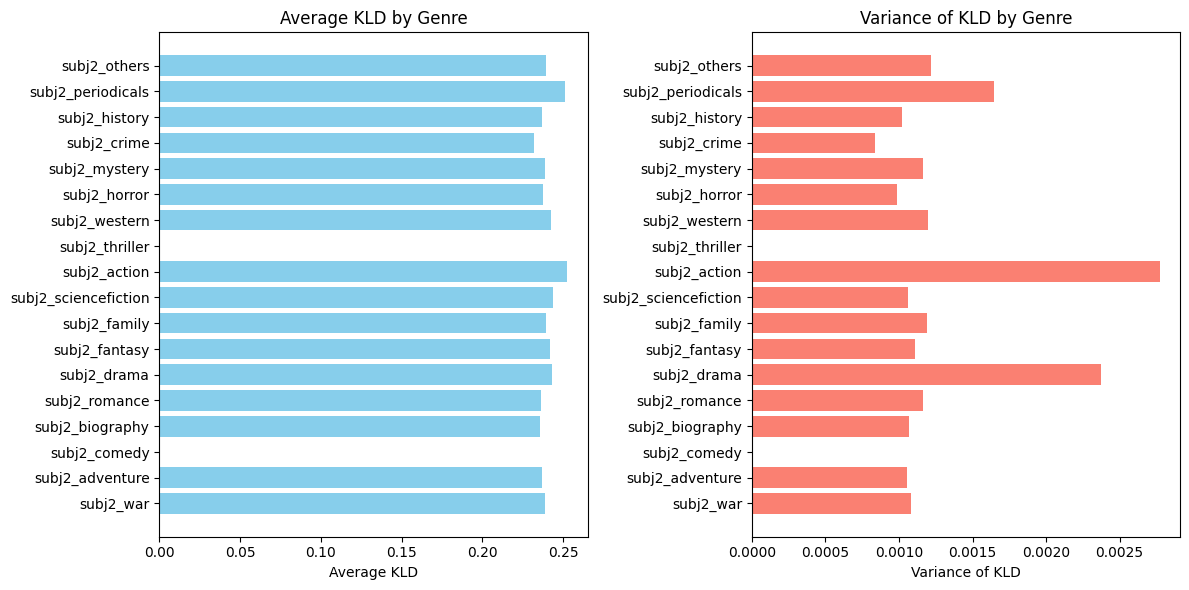

In [22]:
# Aggregate KLD metrics by genre columns to find average values
genre_columns = [col for col in merged_full_df.columns if col.startswith('subj2_')]
genre_kld_analysis = {}

for genre in genre_columns:
    genre_data = merged_full_df[merged_full_df[genre] == 1]
    genre_kld_analysis[genre] = {
        'avg_kld': genre_data['kld_avg'].mean(),
        'var_kld': genre_data['kld_var'].mean(),
        'downloads': genre_data['downloads'].mean()
    }

# Convert to DataFrame for easier analysis
genre_kld_df = pd.DataFrame(genre_kld_analysis).T
genre_kld_df.reset_index(inplace=True)
genre_kld_df.columns = ['Genre', 'Avg KLD', 'Var KLD', 'Avg Downloads']

# Plot the results to observe the trends in Avg KLD and Var KLD across genres
plt.figure(figsize=(12, 6))

# Plot Average KLD
plt.subplot(1, 2, 1)
plt.barh(genre_kld_df['Genre'], genre_kld_df['Avg KLD'], color='skyblue')
plt.xlabel('Average KLD')
plt.title('Average KLD by Genre')

# Plot Variance KLD
plt.subplot(1, 2, 2)
plt.barh(genre_kld_df['Genre'], genre_kld_df['Var KLD'], color='salmon')
plt.xlabel('Variance of KLD')
plt.title('Variance of KLD by Genre')

plt.tight_layout()
plt.show()


The analysis shows that genres like Thriller, Action, and Science Fiction have more unpredictable stories, with lots of twists and turns that keep readers guessing. These genres reveal information in bursts, making the narrative feel more dynamic and engaging. On the other hand, genres like Romance, Biography, and Comedy tend to have more straightforward and predictable stories, where the information is revealed steadily throughout. This aligns with the type of storytelling readers expect from these genres, with fewer surprises but a smoother flow.

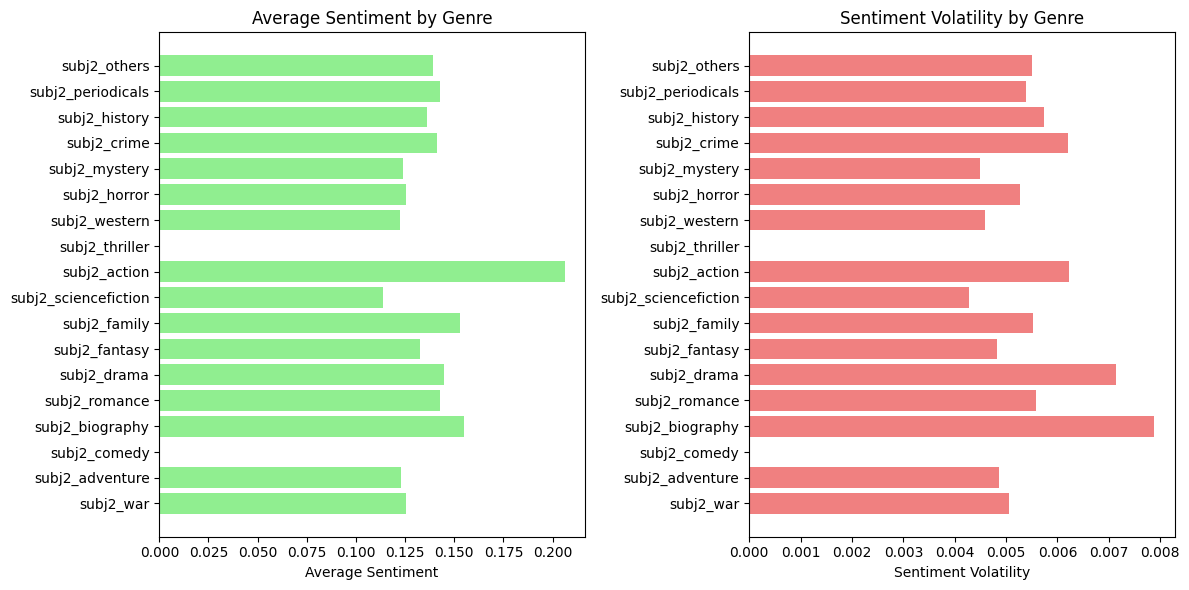

In [24]:
import matplotlib.pyplot as plt

# Aggregate sentiment metrics (average and volatility) by genre
sentiment_genre_analysis = {}

for genre in genre_columns:
    genre_data = merged_full_df[merged_full_df[genre] == 1]
    sentiment_genre_analysis[genre] = {
        'avg_sentiment': genre_data['sentiment_avg'].mean(),
        'vol_sentiment': genre_data['sentiment_vol'].mean(),
    }

# Convert to DataFrame for easier analysis
sentiment_genre_df = pd.DataFrame(sentiment_genre_analysis).T
sentiment_genre_df.reset_index(inplace=True)
sentiment_genre_df.columns = ['Genre', 'Avg Sentiment', 'Sentiment Volatility']

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Average Sentiment
plt.subplot(1, 2, 1)
plt.barh(sentiment_genre_df['Genre'], sentiment_genre_df['Avg Sentiment'], color='lightgreen')
plt.xlabel('Average Sentiment')
plt.title('Average Sentiment by Genre')

# Plot Sentiment Volatility
plt.subplot(1, 2, 2)
plt.barh(sentiment_genre_df['Genre'], sentiment_genre_df['Sentiment Volatility'], color='lightcoral')
plt.xlabel('Sentiment Volatility')
plt.title('Sentiment Volatility by Genre')

plt.tight_layout()
plt.show()


### Predictive Modeling

In [32]:
# Impute missing values for numeric columns (KLD metrics, sentiment features)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on X_train and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check if there are still missing values in the training data
print(f"Remaining missing values in X_train: {pd.isnull(X_train_imputed).sum().sum()}")
print(f"Remaining missing values in X_test: {pd.isnull(X_test_imputed).sum().sum()}")


Remaining missing values in X_train: 0
Remaining missing values in X_test: 0


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feature selection: KLD metrics, sentiment features, and genre attributes
predictors = merged_full_df[['kld_avg', 'kld_var', 'kld_min', 'kld_max', 'kld_range', 'kld_slope',
                             'sentiment_avg', 'sentiment_vol'] + genre_columns]

# Target variable: log of download counts
target = merged_full_df['log_downloads']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)


In [34]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest Model
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest R-squared: {rf_r2}")


Random Forest MSE: 1.1167006468992953
Random Forest R-squared: 0.11272502180263277


In [36]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()

# Fit the model to the imputed training data
lr_model.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_imputed)

# Evaluate the performance of the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr}")
print(f"Linear Regression - R² Score: {r2_lr}")


Linear Regression - Mean Squared Error: 1.0683881959672508
Linear Regression - R² Score: 0.1511117004227418
